In [84]:
import numpy as np
from pyuvdata import UVBeam
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Table of contents

* [Vivaldi efield](#vivaldi_efield). Show parameters only
* [Vivaldi power](#vivaldi_power). Show parameters and plot the beam (easy to plot power beam)
* [RHINO matlab](#rhino_matlab). Plot the beam from the matlab files
* [RHINO UVBeam](#rhino_uvbeam). Plot the beam from a UVBeam file generated from the matlab files

In [85]:
class Grid:
    def __init__(self, dim):
        self.grid = np.zeros((dim, dim))  
        self.dim = dim
        self.num = np.zeros((dim, dim), dtype=int)
        
    def insert(self, x, y, val):   # the physical values range from -1 to 1
        i = np.round((x-(-1))/2*(self.dim-1)).astype(int)
        j = np.round((y-(-1))/2*(self.dim-1)).astype(int)
        
        for k in range(val.size):
            self.grid[i[k], j[k]] += val[k]
            self.num[i[k], j[k]] += 1
        
        for i in range(self.dim):
            for j in range(self.dim):
                if self.grid[i, j]>0 and self.num[i][j] == 0: print("G")
                if self.grid[i, j]==0 and self.num[i][j] > 0: print("G")
                    
            
    def average(self):
        for i in range(self.dim):
            for j in range(self.dim):
                if self.grid[i, j] > 0:
                    self.grid[i, j] /= self.num[i, j]

        #self.grid = np.where(self.grid>0, self.grid/self.num, self.grid)

        
    def log10(self):
        vmin = 1e9
        for i in range(self.dim):
            for j in range(self.dim):
                if self.grid[i, j] > 0:
                    self.grid[i, j] = np.log10(self.grid[i, j])
                    if self.grid[i, j] < vmin: vmin = self.grid[i, j]
                else:
                    self.grid[i, j] = np.nan
                    
        return vmin
        #self.grid = np.where(self.grid>0, np.log10(self.grid), self.grid)
    
    def dB(self):
        vmin = self.log10()
        vmin *= 10
        self.grid *= 10
        return vmin
    
def plot_sky_grid(zenith, azimuth, amplitude, dim, guide_lines=False, save_to=None):
    """
    zenith, azimuth: each is a list of values of length N, together they 
        indicate the location of N sources when looking up at the sky.
    amplitude: The amplitude of the source fluxes, also of length N
    
    Produces a plot of the sources on the sky. Sources with a higher amplitude
    appear brighter.
    
    Compass directions are undetermined.
    """

    zenith_ok = lambda za: np.logical_and(za >= 0, za <= np.pi/2)
    
    azimuth = azimuth[zenith_ok(zenith)]
    amplitude = amplitude[zenith_ok(zenith)]
    zenith = zenith[zenith_ok(zenith)]

    print(azimuth.size, "sources are visible")
    
    grid = Grid(dim)

    ax = plt.axes()
    ax.set_facecolor("black")
  
    # horizon
    points = np.arange(0, 2*np.pi, 0.01)
    x = np.cos(points)
    y = np.sin(points)
    #grid.insert(x, y, np.ones(x.size))
    
    """
    if guide_lines:
        for deg in [ 30, 45, 60, 75 ]:
            r = np.cos(deg*np.pi/180)
            x = r*np.cos(points)
            y = r*np.sin(points)
            plt.text(90*r/np.sqrt(2), -90*r/np.sqrt(2), "    $"+str(deg)+"^\circ$", c="w")
            plt.scatter(x*90, y*90, s=0.01, c='w', marker='o')
    """
    r = np.sin(zenith)
    x = r*np.sin(azimuth)
    y = r*np.cos(azimuth)
    print(np.min(x), np.max(x))
    grid.insert(-x, y, amplitude)
    grid.average()
    #vmin = grid.dB()
    #print(vmin)
    vmin = None
    im = plt.imshow(grid.grid, vmin=vmin, interpolation="quadric")
    plt.text(grid.grid.shape[0]+30, -20, "dB", color="black", fontsize=20)    
    print("Grid min", np.nanmin(grid.grid), "Grid max", np.nanmax(grid.grid))
    #plt.title("Source on the sky at different locations")
    plt.xticks([], [])
    plt.yticks([], [])
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    
    if save_to is not None:
        plt.savefig(save_to+".pdf")

    return grid.grid

In [86]:
def print_UVBeam(uvb):
    print("Naxes_vec", uvb.Naxes_vec)
    print("Nfreqs", uvb.Nfreqs)
    print("antenna_type", uvb.antenna_type)
    print("bandpass_array shape", uvb.bandpass_array.shape)
    print("bandpass_array", uvb.bandpass_array)
    print("beam_type", uvb.beam_type)
    print("data_array shape", uvb.data_array.shape)
    if uvb.future_array_shapes:
        if uvb.beam_type == "healpix":
            print("\t(Naxes_vec, Nfeeds or Npols, Nfreqs, Npixels)")
        else:
            print("\t(Naxes_vec, Nfeeds or Npols, Nfreqs, Naxes2, Naxes1)")
    else:
        if uvb.beam_type == "healpix":
            print("\t(Naxes_vec, 1, Nfeeds or Npols, Nfreqs, Npixels)")
        else:
            print("\t(Naxes_vec, 1, Nfeeds or Npols, Nfreqs, Naxes2, Naxes1)")
       
    
    print("data_normalization", uvb.data_normalization)
    print("feed_name", uvb.feed_name)
    print("feed_version", uvb.feed_version)
    print("freq_array", uvb.freq_array)
    print("future_array_shapes", uvb.future_array_shapes)
    print("history", uvb.history)
    print("model_name", uvb.model_name)
    print("model_version", uvb.model_version)
    print("pixel_coordinate_system", uvb.pixel_coordinate_system)
    print("telescope_name", uvb.telescope_name)
    
    print("------------------------------------------------------")
    
    
    print("Naxes1", uvb.Naxes1)
    print("Naxes2", uvb.Naxes2)
    print("Ncomponents_vec", uvb.Ncomponents_vec)
    print("Nelements", uvb.Nelements)
    print("Nfeeds", uvb.Nfeeds)
    print("Npixels", uvb.Npixels)
    print("Npols", uvb.Npols)
    print("Nspws", uvb.Nspws)
    print("axis1_array shape", uvb.axis1_array.shape)
    print("axis2_array shape", uvb.axis2_array.shape)
    if uvb.basis_vector_array is not None: 
        print("basis_vector_array shape ", uvb.basis_vector_array.shape)
        if uvb.beam_type == "healpix":
            print("\t(Naxes_vec, Ncomponents_vec, Npixels)")
        else:
            print("\t(Naxes_vec, Ncomponents_vec, Naxes2, Naxes1)")
    else: print("uvb.basis_vector_array None")
    print("coupling_matrix", uvb.coupling_matrix)
    print("delay_array", uvb.delay_array)
    print("element_coordinate_system", uvb.element_coordinate_system)
    print("element_location_array", uvb.element_location_array)
    print("extra_keywords", uvb.extra_keywords)
    print("feed_array", uvb.feed_array)
    print("filename", uvb.filename)
    print("freq_interp_kind", uvb.freq_interp_kind)
    print("gain_array", uvb.gain_array)
    print("loss_array", uvb.loss_array)
    print("mismatch_array", uvb.mismatch_array)
    print("nside", uvb.nside)
    print("ordering", uvb.ordering)
    print("pixel_array", uvb.pixel_array)
    print("polarization_array", uvb.polarization_array)
    print("receiver_temperature_array", uvb.receiver_temperature_array)
    print("reference_impedance", uvb.reference_impedance)
    print("s_parameters", uvb.s_parameters)
    print("spw_array", uvb.spw_array)
    print("x_orientation", uvb.x_orientation)
    print("-----------------------------------")

<a id='vivaldi_efield'></a>
## Vivaldi efield beam

Don't know how to plot this (can plot power beam later). However can print parameters.

In [87]:
uvb = UVBeam()
uvb.read("/scratch3/users/hgarsden/local/hgarsden/NF_HERA_Vivaldi_efield_beam.fits")


Print the efield beam parameters, plus some values if arrays are not too big.

In [88]:
print_UVBeam(uvb)

Naxes_vec 2
Nfreqs 201
antenna_type simple
bandpass_array shape (1, 201)
bandpass_array [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1.]]
beam_type efield
data_array shape (2, 1, 2, 201, 181, 360)
	(Naxes_vec, 1, Nfeeds or Npols, Nfreqs, Naxes2, Naxes1)
data_normalization physical
feed_name Vivaldi
feed_version 1.0
freq_array [[5.00e+07 5.10e+07 5.20e+07 5.30e+07 5.40e+07 5.50e+07 5.60e+07 5.70e+07
  5.80e+07 5.90e+07 6.00e

<a id='vivaldi_power'></a>
### Vivaldi Power beam

Power beam can easily be plotted.

In [89]:
uvbp = UVBeam()
uvbp.read("/scratch3/users/hgarsden/local/hgarsden/NF_HERA_Vivaldi_power_beam.fits")


Print the power beam parameters, plus some values if arrays are not too big.

In [90]:
print_UVBeam(uvbp)

Naxes_vec 1
Nfreqs 201
antenna_type simple
bandpass_array shape (1, 201)
bandpass_array [[  571.6881   624.5001   673.4025   716.6329   754.0516   784.5601
    807.1281   821.3956   827.1376   826.5625   821.3956   813.3904
    804.8569   796.9329   790.1721   785.6809   784.       786.2416
    793.5489   807.6964   830.0161   861.4225   903.0025   954.81
   1017.61    1092.3025  1177.1761  1268.7844  1366.0416  1466.1241
   1564.9936  1658.1184  1744.7329  1824.9984  1904.4496  1982.9209
   2063.8849  2145.5424  2227.84    2310.7249  2396.1025  2486.0196
   2583.6889  2689.4596  2806.8804  2931.1396  3060.3024  3186.6025
   3303.9504  3400.0561  3465.6769  3493.9921  3484.5409  3449.2129
   3404.7225  3369.8025  3357.0436  3373.2864  3417.5716  3484.5409
   3567.6729  3659.0401  3751.5625  3836.5636  3913.7536  3981.61
   4048.7769  4121.64    4212.01    4329.64    4476.9481  4647.1489
   4824.6916  4992.8356  5139.4561  5262.0516  5365.5625  5459.7321
   5554.7209  5661.0576  5785.12


Plot the Vivaldi power beam

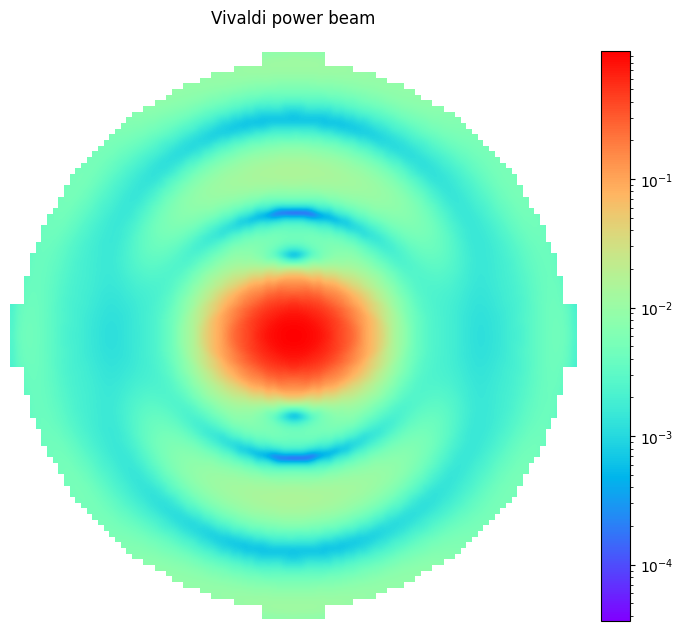

In [91]:
uvbp.interpolation_function = "az_za_simple"
uvbp.freq_interp_kind = "linear"

az = np.arange(360)
za = np.arange(90)

az = np.tile(az, 90)
az = np.deg2rad(az)
za = np.repeat(za, 360)
za = np.deg2rad(za)

interp_beam = uvbp.interp(az, za, freq_array=np.array([1.00e+08]))[0]
interp_beam = interp_beam[0, 0, 0, 0]       

values = np.abs(interp_beam)    # abs because the values are complex and there are non-zero imag components (why?)


grid = Grid(100)
r = np.sin(za)
x = r*np.sin(az)
y = r*np.cos(az)

grid.insert(-x, y, values)
grid.average()
grid.grid = np.where(grid.grid==0, np.nan, grid.grid)


plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.axis("off")
im=plt.imshow(grid.grid, interpolation="quadric", norm=LogNorm(), cmap="rainbow")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("Vivaldi power beam\n")
plt.savefig("vivaldi")

<a id='rhino_matlab'></a>
## RHINO Beam from matlab

Use the data from the files. From the za and az, calculate points on an x/y grid and insert power values (if more than 1 value goes to an x/y point they are averaged). The matlab values are assumed to be dB so they are converted to values 10**(dB/10). Then the values are plotted on log scale.

There are positive and negative za in the matlab files. The za that are negative have the effect of selecting an x/y grid point that has an az rotated by PI. In other words, the same x/y grid point corresponds to 
```
1. za, az+PI
2. -za, az
```
This means that if the negative za are used as well as the positive, each x/y grid point is hit twice with different power values.

I only use za > 0.

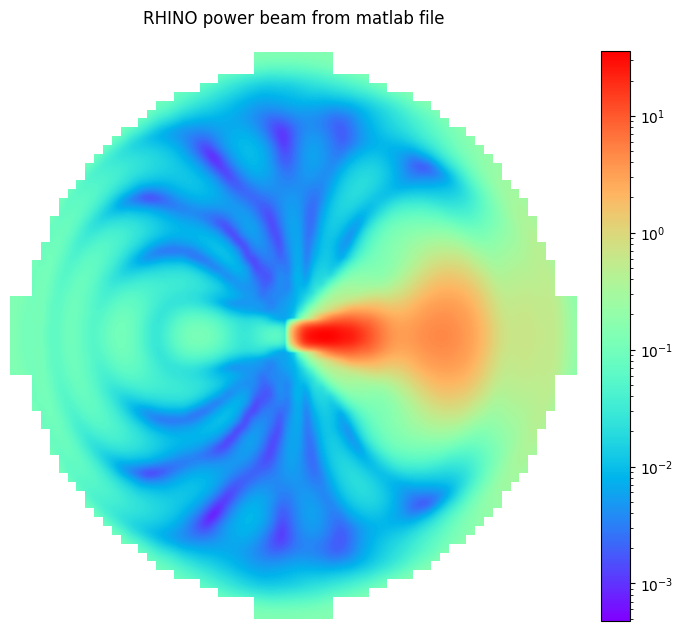

In [92]:
az = np.arange(361)
za = np.arange(91)

values = np.loadtxt("matlab_horn_351MHz.dat")   # za by az
# The values are indexed first by za which goes -90 to 90. I only want 0 to 90.
values = values[-91:]

# Replicate the az/za into long array the size of values, so that each value has an az/za
az = np.tile(az, values.shape[0])
az = np.deg2rad(az)
za = np.repeat(za, values.shape[1])
za = np.deg2rad(za)
values = values.ravel()
values = 10**(values/10)     # From dB to power

grid = Grid(64)
r = np.sin(za)
x = r*np.sin(az)
y = r*np.cos(az)

grid.insert(-x, y, values)
grid.average()
grid.grid = np.where(grid.grid==0, np.nan, grid.grid)

plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.axis("off")
im=plt.imshow(grid.grid, interpolation="quadric", norm=LogNorm(), cmap="rainbow")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("RHINO power beam from matlab file\n")
plt.savefig("rhino_matlab")

<a id='rhino_uvbeam'></a>
## RHINO Beam as UVBeam

Create a UVBeam object from the RHINO beam matlab files and load the UVBeam object.

The UVBeam has been given 208 frequencies because that is used in further simulations. The beam has been made identical for every frequency (wrong).

In [93]:
rhino = UVBeam()
rhino.read("rhino_matlab1.beamfits")


Print rhino beam parameters and some values.

In [94]:
print_UVBeam(rhino)

Naxes_vec 1
Nfreqs 280
antenna_type simple
bandpass_array shape (1, 280)
bandpass_array [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
beam_type power
data_array shape (1, 1, 1, 280

Plot the RHINO beam from the UVBeam files using the same method as for the Vivaldi power beam.

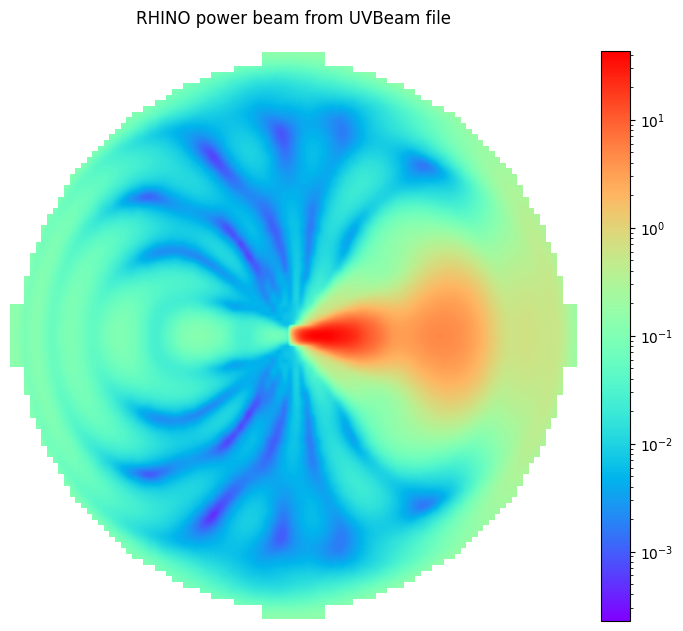

In [95]:

az = np.arange(360)
za = np.arange(90)

az = np.tile(az, 90)
az = np.deg2rad(az)
za = np.repeat(za, 360)
za = np.deg2rad(za)

interp_beam = rhino.interp(az, za, freq_array=np.array([60e+06]))[0]
interp_beam = interp_beam[0, 0, 0, 0]       

values = np.abs(interp_beam)    # abs because the values are complex and there are non-zero imag components (why?)


grid = Grid(100)
r = np.sin(za)
x = r*np.sin(az)
y = r*np.cos(az)

grid.insert(-x, y, values)
grid.average()
grid.grid = np.where(grid.grid==0, np.nan, grid.grid)


plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.axis("off")
im=plt.imshow(grid.grid, interpolation="quadric", norm=LogNorm(), cmap="rainbow")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("RHINO power beam from UVBeam file\n")
plt.savefig("rhino_uvbeam")

## What vis_cpu does

Cut out relevant code.

In [96]:
uvb.interpolation_function = "az_za_simple"
uvb.freq_interp_kind = "linear"
uvb.polarization_array = ["XX", "YY"]

# For zenith angle of zero the second e-field component is big and the first near 0.
# For zenith angle of 90deg both values are small.
az = np.array([np.deg2rad(0)])
za = np.array([np.deg2rad(0)])
interp_beam = uvb.interp(np.array(az), np.array(za), freq_array=np.array([1.00e+08]))[0]

interp_beam = interp_beam[:, 0, :, 0, :]       # nax, nfeed, nsrcs_up

# Specify number of polarizations (axes/feeds)
polarized = True      # for this beam
if polarized:
    nax = nfeed = 2
else:
    nax = nfeed = 1
nbeam = 1
nsrcs_up = len(az)     # as in az/za length

A_s = np.zeros((nax, nfeed, nbeam, nsrcs_up), dtype=complex)

which_beam = 0
A_s[:, :, which_beam] = interp_beam
A_s = A_s.transpose((1, 2, 0, 3))  # Now (Nfeed, Nbeam, Nax, Nsrc)
#print(A_s.shape)

# Now A_s is multiplied by v that contains delays and source flux.
# A_s has shape (Nfeed, Nbeams, Nax, Nsources)
# v has shape (Nants, Nsources up) and is sqrt(I)*exp(1j tau*nu)
# Here we expand A_s to all ants (from its beams), then broadcast to v, so we
# end up with shape (Nax, Nfeed, Nants, Nsources)    WRONG
# Multiply (Nfeed, NBeam, Nax, Nsources_up) * (1, Nants, 1, Nsources up) element
# by element and because nbeam == nant we get (Nfeed, NBeam, Nax, Nsources_up)

nant = 1
v = np.ones((nant, nsrcs_up), dtype=complex)

beam_idx = [ 0 for i in range(nant) ]
v = A_s[:, beam_idx] * v[np.newaxis, :, np.newaxis, :] 
v = np.moveaxis(v, 2, 1)
print(v.shape)
v = v.reshape((nfeed * nant, nax * nsrcs_up))  # reform into matrix
print(v.shape)
print("V", v)

# Now multiplied by itself
vis = v.conj().dot(v.T)
print(vis.shape)


# Now what is the beam
for na in range(nax):
    for nf in range(nfeed):
        for ns in range(nsrcs_up):
            print("Ax", na, "Feed", nf, "Source", ns, "Beam", interp_beam[na, nf, ns], np.linalg.norm(interp_beam[na, nf, ns]))

(2, 2, 1, 1)
(2, 2)
V [[-0.20358877+2.93956255e-02j  6.39162938+5.85219956e+01j]
 [ 6.39162938+5.85219956e+01j  0.20358877-2.93956255e-02j]]
(2, 2)
Ax 0 Feed 0 Source 0 Beam (-0.20358876982875898+0.02939562551830821j) 0.20570000000000005
Ax 0 Feed 1 Source 0 Beam (6.391629378482308+58.521995641708266j) 58.87
Ax 1 Feed 0 Source 0 Beam (6.391629378482309+58.52199564170828j) 58.87000000000001
Ax 1 Feed 1 Source 0 Beam (0.20358876982875898-0.029395625518308183j) 0.20570000000000005


In [97]:
print(uvb.basis_vector_array[0, 0, :, :])
print(uvb.basis_vector_array[0, 1, :, :])
print(uvb.basis_vector_array[1, 0, :, :])
print(uvb.basis_vector_array[1, 1, :, :])

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
